## Traffic Sign Recognition with Tensorflow Keras

The goal is to build a model that can detect and classify traffic signs in a video stream taken from a moving car. Given an image of a traffic sign, our model should be able to tell it's type (*e.g. Stop sign, speed limit, yield sign*). We'll work with images that are properly cropped such that the traffic sign takes most of the image. So don't worry about edge cases as of now.

You are free to use either Keras or Pytorch.

We will use the **Belgian Traffic Sign** Dataset because it is big enough to train on, and yet small enough to be easy to work with.

You can download the dataset from : http://people.ee.ethz.ch/~timofter/traffic_signs/index.html

There are a lot of datasets on that page, but you only need the two files listed under BelgiumTS for Classification (cropped images):



1.   BelgiumTSC_Training 
2.   BelgiumTSC_Testing



The images in this dataset are in an old .ppm format. So old, in fact, that most tools don’t support it. Which meant that we cann’t casually browse the folders to take a look at the images. Luckily, the Scikit Image library recognizes this format. This code below will load the data and return two lists: images and labels.

In [0]:
# Another web link to download the dataset
#! wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
#! unzip -q BelgiumTSC_Training.zip
#! wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
#! unzip -q BelgiumTSC_Testing.zip

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/Deep Learning Class/Project/Belgian Traffic Sign Detector"

#Preprocessing of Dataset
I have done the preprocessing of the image files in the following notebook uploaded in Github.
I have usked Skimage package to convert .ppm format to numpy array
Numpy files are saved in .npy format and uploaded in my google drive.

https://github.com/dee-walia20/Belgian_Traffic_Sign_Detector/blob/master/data_preprocessing.ipynb


In [0]:
import numpy as np
import os
X_train = np.load(os.path.join(root_dir,"train_images_numpy.npy"))
X_test = np.load(os.path.join(root_dir,"test_images_numpy.npy"))

![picture](https://drive.google.com/uc?id=1BMOBI15uhip7e16qUR9n-rnSDQQlLv1p)

In [5]:
print(np.shape(X_train))
print(np.shape(X_test))

(4575, 64, 64, 3)
(2520, 64, 64, 3)


In [0]:
from tensorflow.keras.utils import to_categorical
y_train = np.load(os.path.join(root_dir,"train_labels_numpy.npy"))
y_train = to_categorical(y_train, num_classes=62)

y_test = np.load(os.path.join(root_dir,"test_labels_numpy.npy"))
y_test = to_categorical(y_test, num_classes=62)

In [7]:
print(np.shape(y_train))
print(np.shape(y_test))

(4575, 62)
(2520, 62)


#Visualization of each image class

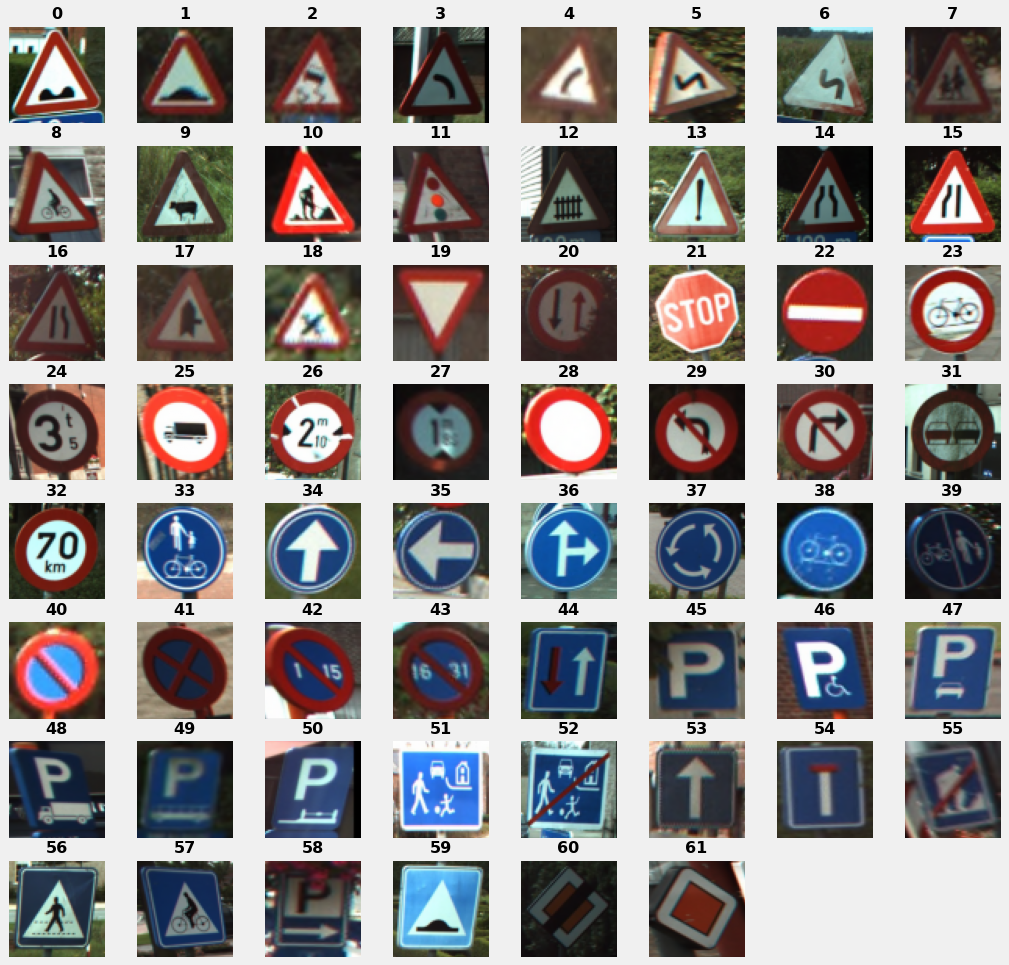

In [8]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,16))
for j, label in enumerate(np.unique(np.argmax(y_train, axis=1))):
    for i,img in enumerate(X_train):
        if label == np.argmax(y_train, axis=1)[i]:
            plt.subplot(8,8,j+1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.title(label, fontsize=16,fontweight='bold')
            plt.imshow(img)
            break

In [0]:
label_num = np.load(os.path.join(root_dir,"train_labels_numpy.npy"))

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=label_num)

In [11]:
print(np.shape(X_train))
print(np.shape(X_val))

(3660, 64, 64, 3)
(915, 64, 64, 3)


#Data Augumentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.15,
                             height_shift_range=0.15,
                             zoom_range=0.15)

In [0]:
train_aug = datagen.flow(X_train, y_train,batch_size=128)

In [0]:
test_datagen=ImageDataGenerator()

In [0]:
val_aug = test_datagen.flow(X_val,y_val, batch_size=128, shuffle=False)
test_aug = test_datagen.flow(X_test,y_test, batch_size=128, shuffle=False)

#Create Model using pre-trained VGG16

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import ResNet50V2

In [0]:
IMG_Height = 64
IMG_Width = 64

In [18]:
model_1 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_Height, IMG_Width,3))

for layer in model_1.layers[:177]:
    layer.trainable = False

for layer in model_1.layers[177:]:
    layer.trainable = True

x = model_1.output

x = Conv2D(64,3,padding = 'same', activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001))(x)
x = Dropout(0.2)(x)
x = Dense(62, activation='softmax' )(x)

model = Model(inputs = model_1.input, outputs = x)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

94674944/94668760 [==============================] - 1s 0us/step


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [0]:
tf.config.experimental_run_functions_eagerly(True)
#In TensorFlow 2.0, Eager execution lets you run the code step-by-step to inspect shapes, 
#data types and values. Certain APIs, like tf.function, tf.keras, etc. are designed to use Graph execution, 
#for performance and portability. When debugging, use tf.config.experimental_run_functions_eagerly(True) 
#to use Eager execution inside this code.

#Model Training

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
file_path="train_model.hdf5"
checkpoint = ModelCheckpoint(filepath = file_path, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')
history = model.fit(train_aug, validation_data=val_aug, 
                    callbacks=checkpoint, steps_per_epoch= (3660 // 128), 
                    epochs=500)

Epoch 1/500
28/28 [==============================] - 13s 471ms/step - loss: 4.5991 - accuracy: 0.1025 - val_loss: 4.5054 - val_accuracy: 0.1934
Epoch 2/500
28/28 [==============================] - 12s 430ms/step - loss: 4.4360 - accuracy: 0.2500 - val_loss: 4.3659 - val_accuracy: 0.3202
Epoch 3/500
28/28 [==============================] - 12s 428ms/step - loss: 4.2837 - accuracy: 0.3768 - val_loss: 4.2024 - val_accuracy: 0.4197
Epoch 4/500
28/28 [==============================] - 12s 431ms/step - loss: 4.1513 - accuracy: 0.4773 - val_loss: 4.1266 - val_accuracy: 0.5115
Epoch 5/500
28/28 [==============================] - 12s 425ms/step - loss: 4.0789 - accuracy: 0.5243 - val_loss: 4.0578 - val_accuracy: 0.5311
Epoch 6/500
28/28 [==============================] - 12s 427ms/step - loss: 4.0240 - accuracy: 0.5680 - val_loss: 3.9820 - val_accuracy: 0.5978
Epoch 7/500
28/28 [==============================] - 12s 427ms/step - loss: 3.9696 - accuracy: 0.6016 - val_loss: 3.9571 - val_accuracy:

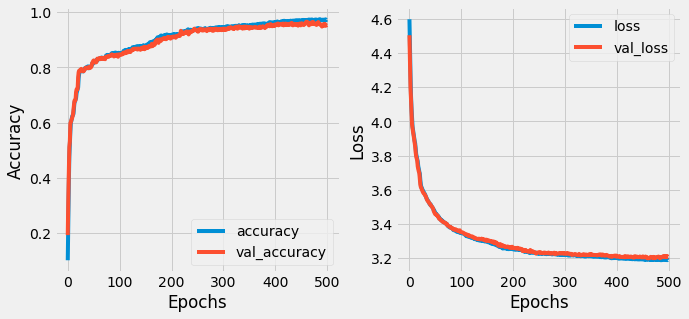

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=14)
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize=14)
plt.show()

# Model Evaluation

In [24]:
model.evaluate(test_aug)[1]

20/20 [==============================] - 3s 145ms/step - loss: 3.2578 - accuracy: 0.9024


0.9023809432983398

In [25]:
model.evaluate(X_test,y_test)[1]

79/79 [==============================] - 10s 127ms/step - loss: 3.2578 - accuracy: 0.9024


0.9023809432983398

In [0]:
y_test = np.argmax(y_test,axis=1)
y_pred = model.predict(X_test, batch_size=128)
y_pred = np.argmax(y_pred,axis=1)

In [27]:
from sklearn.metrics import classification_report
import pandas as pd
report = classification_report(y_test, y_pred,output_dict=True)
df = pd.DataFrame(report).transpose()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Visualiztion of Accuracy on each image class

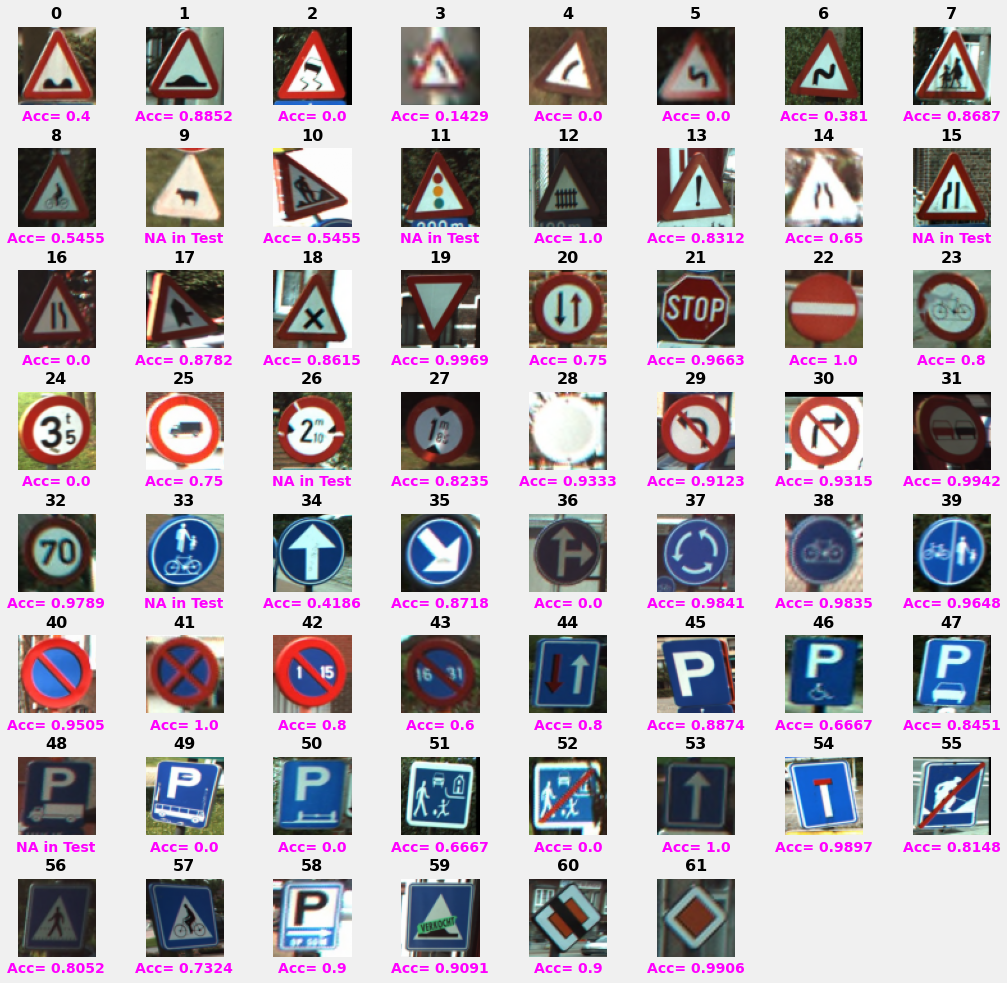

In [28]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.5)
for j, label in enumerate(np.unique(np.argmax(y_train, axis=1))):
    for i,img in enumerate(X_train):
        if label == np.argmax(y_train, axis=1)[i]:
            plt.subplot(8,8,j+1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.title(label, fontsize=16,fontweight='bold')
            if str(j) in list(df.index):
                plt.xlabel('Acc= ' + str(round(df['f1-score'][str(j)],4)),color='magenta', fontsize=14,fontweight='bold')
            else:
                plt.xlabel('NA in Test', color='magenta', fontsize=14, fontweight='bold')
            plt.imshow(img)
            break